In [1]:
import numpy as np
import xarray as xr
import cftime
import matplotlib as mpl
import matplotlib.pyplot as plt



# put the PDF computing function here
# put lat-lon specs
# make lon-wise pdf for 585,246,g6solar and sulfur
# make a ridge plot

# -------
# 585    |
#        | here the gausiian will be red and towards right
# -------
# -------
# 245    |
#        | here the gasian will be slightly red
# -------
# -------
# G6sul  |
#        | here the gasian will same as 245 . On the RHS panels plot diff G6-245 and G6-585
# -------
# -------
# G6sol  |
#        | here the gasian will same as 245 . On the RHS panels plot diff G6-245 and G6-585
# -------


# Put the whole above on left for first 30 and then on right last 30

In [2]:
import xarray as xr
from pathlib import Path
import myfunctions as mf

In [3]:
# =========================
# User-defined metadata
# =========================

varname = "tas"

# =========================
# Base CEDA paths
# =========================

CEDA_BASE = Path("/badc/cmip6/data/CMIP6")

In [4]:
#Model Names
MODELS = {
    "UKESM1-0-LL":  {"institution": "MOHC",         "ensemble": "r1i1p1f2",  "grid": "gn",},
    "CNRM-ESM2-1":  {"institution": "CNRM-CERFACS", "ensemble": "r1i1p1f2",  "grid": "gr",},
    # "MPI-ESM1-2-LR":{"institution": "MPI-M",        "ensemble": "r1i1p1f1",  "grid": "gn",},
    # "CESM2-WACCM":  {"institution": "NCAR",         "ensemble": "r1i1p1f1",  "grid": "gn",},
    # "IPSL-CM6A-LR": {"institution": "IPSL",         "ensemble": "r1i1p1f1",  "grid": "gr",},
}


In [5]:
#Experiment details
EXPERIMENTS = {
    # "HIST":     {"project": "CMIP",        "scenario": "historical", "color": "black"},
    "SSP245":   {"project": "ScenarioMIP", "scenario": "ssp245"},
    "SSP585":   {"project": "ScenarioMIP", "scenario": "ssp585"},
    "G6solar":  {"project": "GeoMIP",      "scenario": "G6solar"},
    "G6sulfur": {"project": "GeoMIP",      "scenario": "G6sulfur"},
}

In [6]:
counts_all = {}

for model_name, model_meta in MODELS.items():

    counts_all[model_name] = {}

    for exp, meta in EXPERIMENTS.items():

        if model_name == "CESM2-WACCM":
            ensemble = "r1i1p1f2" if meta["scenario"] == "G6sulfur" else "r1i1p1f1"
        else:
            ensemble = model_meta["ensemble"]

        base = (
            CEDA_BASE
            / meta["project"]
            / model_meta["institution"]
            / model_name
            / meta["scenario"]
            / ensemble
            / "day"
            / varname
            / model_meta["grid"]
            / "latest"
        )

        print(f"Reading {model_name} {exp} {base}")
        ds = mf.open_files(str(base))
        da = mf.read_var(ds, varname)

        # --- PROCESS INSIDE EXP LOOP ---
        
        if model_name == "CESM2-WACCM":
            da = da.sel(
                time=slice(
                    cftime.DatetimeNoLeap(2071, 1, 1),
                    cftime.DatetimeNoLeap(2100, 12, 30)   # or the last date in your dataset
                )
            )
            da=da.load()
        else:
            da = da.sel(time=slice("2071-01-01", "2100-12")).load()

        # da = da.resample(time="1D").mean()   # remove *86400 for tas

        da_tropics = da.sel(lat=slice(-15, 15))

        values = da_tropics.values.flatten() - 273.0 
        values = values[np.isfinite(values)]

        # bin_edges_ref = np.arange(10, 40, 1)

        # lon_hist = {}
        
        # for lon in da_tropics.lon.values:
        
        #     da_lon = da_tropics.sel(lon=lon)
        
        #     # flatten over time × lat
        #     values = da_lon.values.flatten() - 273.15
        #     values = values[np.isfinite(values)]
        
        #     if len(values) == 0:
        #         continue
        
        #     counts, edges = np.histogram(values, bins=bin_edges_ref)
        #     percent = 100 * counts / counts.sum()
        
        #     lon_hist[float(lon)] = {
        #         "counts": counts,
        #         "percent": percent,
        #     }
        bin_edges_ref = np.arange(10, 40, 1)
        bin_centers = 0.5 * (bin_edges_ref[:-1] + bin_edges_ref[1:])
        
        lons = da_tropics.lon.values
        nlon = len(lons)
        nbin = len(bin_centers)
        
        freq_2d = np.zeros((nlon, nbin))
        
        for i, lon in enumerate(lons):
        
            da_lon = da_tropics.sel(lon=lon)
        
            values = da_lon.values.flatten() - 273.15
            values = values[np.isfinite(values)]
        
            if len(values) == 0:
                continue
        
            counts, _ = np.histogram(values, bins=bin_edges_ref)
            percent = 100 * counts / counts.sum()
        
            freq_2d[i, :] = percent

        # --- STORE ---
        # counts_all[model_name][exp] = {
        #     "lon_hist": lon_hist,
        #     "bin_edges": bin_edges_ref,
        # }
        counts_all[model_name][exp] = {
            "freq_2d": freq_2d,
            "lon": lons,
            "bin_centers": bin_centers,
        }

Reading UKESM1-0-LL SSP245 /badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/r1i1p1f2/day/tas/gn/latest
Reading UKESM1-0-LL SSP585 /badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/day/tas/gn/latest
Reading UKESM1-0-LL G6solar /badc/cmip6/data/CMIP6/GeoMIP/MOHC/UKESM1-0-LL/G6solar/r1i1p1f2/day/tas/gn/latest
Reading UKESM1-0-LL G6sulfur /badc/cmip6/data/CMIP6/GeoMIP/MOHC/UKESM1-0-LL/G6sulfur/r1i1p1f2/day/tas/gn/latest
Reading CNRM-ESM2-1 SSP245 /badc/cmip6/data/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-ESM2-1/ssp245/r1i1p1f2/day/tas/gr/latest
Reading CNRM-ESM2-1 SSP585 /badc/cmip6/data/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-ESM2-1/ssp585/r1i1p1f2/day/tas/gr/latest
Reading CNRM-ESM2-1 G6solar /badc/cmip6/data/CMIP6/GeoMIP/CNRM-CERFACS/CNRM-ESM2-1/G6solar/r1i1p1f2/day/tas/gr/latest
Reading CNRM-ESM2-1 G6sulfur /badc/cmip6/data/CMIP6/GeoMIP/CNRM-CERFACS/CNRM-ESM2-1/G6sulfur/r1i1p1f2/day/tas/gr/latest


In [13]:
counts_all

{'UKESM1-0-LL': {'SSP245': {'freq_2d': array([[0.        , 0.        , 0.        , ..., 2.20840139, 1.74514924,
           1.20042057],
          [0.        , 0.        , 0.        , ..., 2.25528054, 1.71985981,
           1.10147018],
          [0.        , 0.        , 0.        , ..., 1.58802546, 0.95227421,
           0.43594371],
          ...,
          [0.        , 0.        , 0.        , ..., 2.13289423, 1.67725688,
           1.06276637],
          [0.        , 0.        , 0.        , ..., 2.15713208, 1.47342762,
           0.74677398],
          [0.        , 0.        , 0.        , ..., 2.1797711 , 1.52854997,
           0.82931966]], shape=(192, 29)),
   'lon': array([  0.9375,   2.8125,   4.6875,   6.5625,   8.4375,  10.3125,
           12.1875,  14.0625,  15.9375,  17.8125,  19.6875,  21.5625,
           23.4375,  25.3125,  27.1875,  29.0625,  30.9375,  32.8125,
           34.6875,  36.5625,  38.4375,  40.3125,  42.1875,  44.0625,
           45.9375,  47.8125,  49.6875,  51

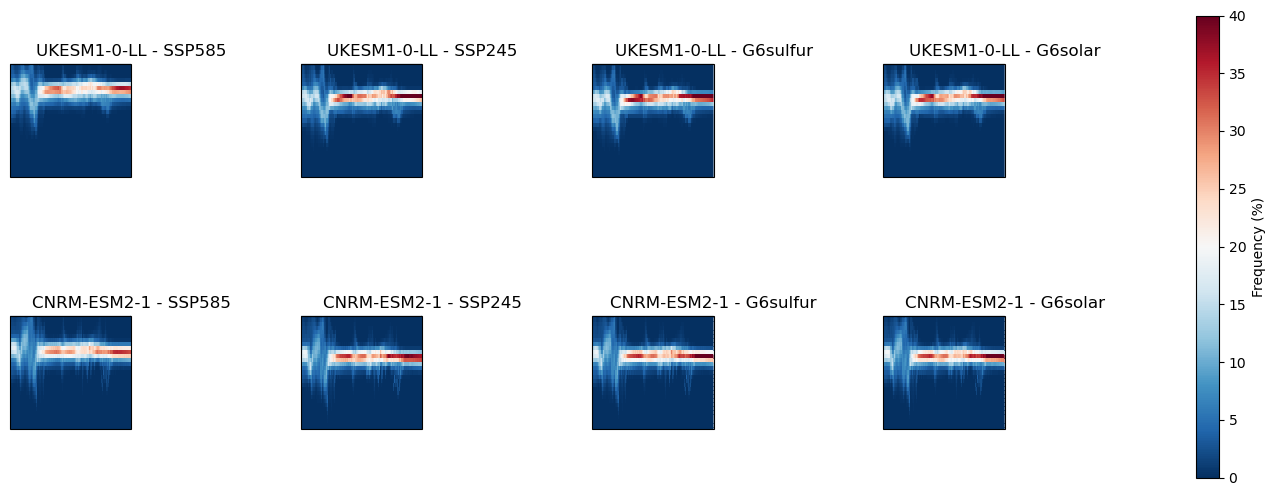

In [24]:
import cartopy.crs as ccrs

fig, axes = plt.subplots(
    nrows=len(counts_all),
    ncols=4,
    figsize=(18, 3 * len(counts_all)),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

for row, model in enumerate(counts_all):

    for col, exp in enumerate(["SSP585", "SSP245", "G6sulfur", "G6solar"]):

        ax = axes[row, col]

        data = counts_all[model][exp]["freq_2d"]
        lon = counts_all[model][exp]["lon"]
        temp = counts_all[model][exp]["bin_centers"]

        Lon, Temp = np.meshgrid(lon, temp)

        cf = ax.pcolormesh(
            lon,
            temp,
            data.T,
            cmap="RdBu_r",
            shading="nearest",
            vmin=0,
            vmax=40
        )

        ax.set_title(f"{model} - {exp}")
        ax.set_xlim(0, 360)
        ax.set_ylim(temp.min(), temp.max())
        ax.set_aspect(360/30 * 0.5)

fig.colorbar(cf, ax=axes.ravel().tolist(), label="Frequency (%)")

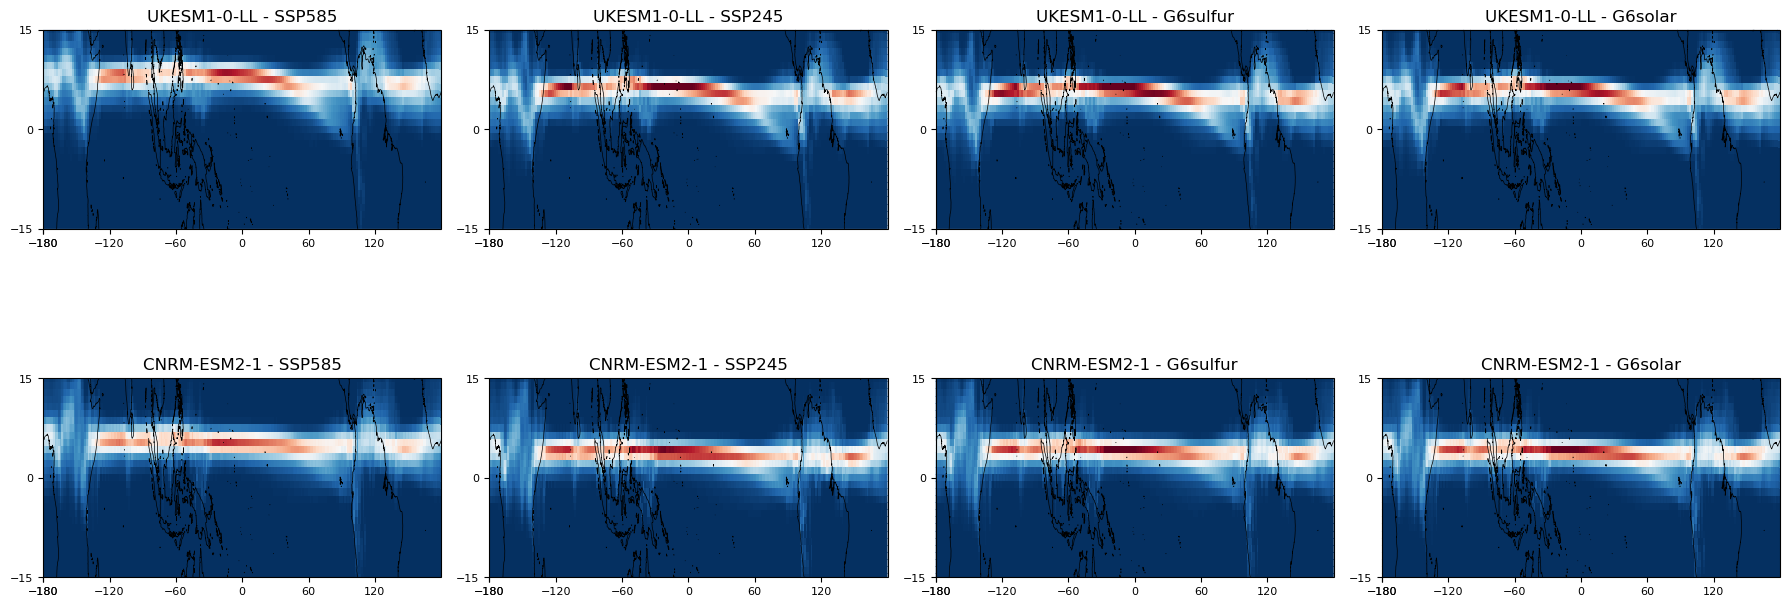

In [34]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axes = plt.subplots(
    nrows=len(counts_all),
    ncols=4,
    figsize=(18, 4 * len(counts_all)),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}
)

for row, model in enumerate(counts_all):

    for col, exp in enumerate(["SSP585", "SSP245", "G6sulfur", "G6solar"]):

        ax = axes[row, col]

        data = counts_all[model][exp]["freq_2d"]
        lon = counts_all[model][exp]["lon"]
        temp = counts_all[model][exp]["bin_centers"]

        # --- map temperature bins to tropical latitude band ---
        lat_min, lat_max = -15, 15
        lat_plot = lat_min + (lat_max - lat_min) * (
            (temp - temp.min()) / (temp.max() - temp.min())
        )

        Lon, Lat = np.meshgrid(lon, lat_plot)

        cf = ax.pcolormesh(
            Lon,
            Lat,
            data.T,
            transform=ccrs.PlateCarree(),
            cmap="RdBu_r",
            shading="auto",
            vmin=0,
            vmax=40
        )

        ax.set_extent([0, 360, -15, 15], crs=ccrs.PlateCarree())

        ax.coastlines(linewidth=0.5)
        # ax.add_feature(cfeature.BORDERS, linewidth=0.3)

        ax.set_title(f"{model} - {exp}")

        # --- Proper longitude ticks ---
        ax.set_xticks(np.arange(0, 361, 60), crs=ccrs.PlateCarree())
        ax.set_yticks([-15, 0, 15], crs=ccrs.PlateCarree())

        ax.tick_params(labelsize=8)
        ax.set_aspect(360/30 * 0.5)

# shared colorbar
# cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.05)
cbar.set_label("Frequency (%)")

plt.tight_layout()
plt.show()

In [31]:
counts_all["UKESM1-0-LL"]["SSP245"]["lon"]

array([  0.9375,   2.8125,   4.6875,   6.5625,   8.4375,  10.3125,
        12.1875,  14.0625,  15.9375,  17.8125,  19.6875,  21.5625,
        23.4375,  25.3125,  27.1875,  29.0625,  30.9375,  32.8125,
        34.6875,  36.5625,  38.4375,  40.3125,  42.1875,  44.0625,
        45.9375,  47.8125,  49.6875,  51.5625,  53.4375,  55.3125,
        57.1875,  59.0625,  60.9375,  62.8125,  64.6875,  66.5625,
        68.4375,  70.3125,  72.1875,  74.0625,  75.9375,  77.8125,
        79.6875,  81.5625,  83.4375,  85.3125,  87.1875,  89.0625,
        90.9375,  92.8125,  94.6875,  96.5625,  98.4375, 100.3125,
       102.1875, 104.0625, 105.9375, 107.8125, 109.6875, 111.5625,
       113.4375, 115.3125, 117.1875, 119.0625, 120.9375, 122.8125,
       124.6875, 126.5625, 128.4375, 130.3125, 132.1875, 134.0625,
       135.9375, 137.8125, 139.6875, 141.5625, 143.4375, 145.3125,
       147.1875, 149.0625, 150.9375, 152.8125, 154.6875, 156.5625,
       158.4375, 160.3125, 162.1875, 164.0625, 165.9375, 167.8